# Vector Security TTP Analysis and Breach Prediction Tool

**Purpose:**
This notebook builds a data-driven tool to answer the question,
“Is it likely that a company's specific TTP exposures will lead to a successful breach?”

The project includes:
- A descriptive method using K-Means clustering
- A predictive method using a Random Forest classifier
- Data cleaning, feature engineering, and visualization
- Interactive queries and a simple dashboard for decision support
- Basic logging and a placeholder authentication function for security

In [1]:

from collections import Counter
import getpass
from hdbscan import HDBSCAN
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, Dropdown, fixed
from lightgbm import LGBMClassifier, early_stopping
import logging

from math import pi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import umap
import warnings

In [2]:
# Setup logging to monitor the tool’s operation
logging.basicConfig(level=logging.INFO,
                    filename='security_tool.log',
                    format='%(asctime)s:%(levelname)s:%(message)s')
logger = logging.getLogger()
logger.info("Notebook started processing.")


In [3]:
# Load the training and testing datasets
train_path = 'data/Train_data.csv'
test_path = 'data/Test_data.csv'

try:
    df_train = pd.read_csv(train_path)
    logger.info("Training dataset loaded successfully with shape: %s", df_train.shape)
except Exception as e:
    logger.error("Error loading training dataset: %s", e)
    raise

try:
    df_test = pd.read_csv(test_path, low_memory=False)
    logger.info("Testing dataset loaded successfully with shape: %s", df_test.shape)
except Exception as e:
    logger.error("Error loading testing dataset: %s", e)
    raise

df_train = df_train[df_train['MitreTechniques'].notna() & (df_train['MitreTechniques'] != '')]
df_test = df_test[df_test['MitreTechniques'].notna() & (df_test['MitreTechniques'] != '')]

# Display the first few rows of the training dataset for inspection
display(df_train.head())

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
4,1546188226889,460,4569,1819,2024-06-04T20:13:35.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,NaN,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630
5,687194767993,987,41659,1509320,2024-06-04T22:33:12.000Z,13,11,InitialAccess,T1566,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
7,678604834796,39,25899,8379,2024-06-14T20:43:34.000Z,6,5,InitialAccess,T1566,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
12,481036341081,194,669,1644638,2024-06-05T00:56:53.000Z,137,116,Impact,T1485,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
14,678604838045,104,316,2276,2024-06-10T13:44:26.000Z,11,9,InitialAccess,T1566,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [4]:
# Define lists of columns to drop
cols_with_many_nulls = [
    'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily',
    'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'
]
dropped_cols = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
                'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
                'FolderPath', 'ResourceIdName', 'FileName', 'ApplicationId', 'ApplicationName',
                'Id', 'OrgId','DetectorId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle', 'OAuthApplicationId', 'CountryCode', 'State', 'City', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'Timestamp'
                ]

# Drop these columns from training and testing data (if they exist)
df_train.drop(columns=cols_with_many_nulls + dropped_cols, inplace=True, errors='ignore')
df_test.drop(columns=cols_with_many_nulls + dropped_cols, inplace=True, errors='ignore')

# Map IncidentGrade to binary outcome: 1 if "TruePositive", 0 otherwise
df_train['Outcome'] = df_train['IncidentGrade'].apply(lambda x: 1 if x == 'TruePositive' else 0)
df_test['Outcome'] = df_test['IncidentGrade'].apply(lambda x: 1 if x == 'TruePositive' else 0)

df_train.drop(columns='IncidentGrade', inplace=True, errors='ignore')
df_test.drop(columns='IncidentGrade', inplace=True, errors='ignore')

# Analyze class distribution
train_distribution = df_train['Outcome'].value_counts()
test_distribution = df_test['Outcome'].value_counts()


# Print the distribution details
print("Training data class distribution:")
print(train_distribution)
print("\nTesting data class distribution:")
print(test_distribution)

Training data class distribution:
Outcome
0    1193732
1     829608
Name: count, dtype: int64

Testing data class distribution:
Outcome
0    543835
1    377256
Name: count, dtype: int64


In [5]:


# Separate majority and minority classes
train_majority_class = df_train[df_train['Outcome'] == 0]
train_minority_class = df_train[df_train['Outcome'] == 1]
test_majority_class = df_test[df_test['Outcome'] == 0]
test_minority_class = df_test[df_test['Outcome'] == 1]

# Downsample majority class to match the size of the minority class
train_majority_downsampled = resample(
    train_majority_class,
    replace=False,  # Sample without replacement
    n_samples=50000,  # Match the minority class size
    random_state=42  # For reproducible results
)

train_minority_downsampled = resample(
    train_minority_class,
    replace=False,  # Sample without replacement
    n_samples=50000,  # Match the minority class size
    random_state=42  # For reproducible results
)

# Define the fraction of the majority class to keep
fraction_to_keep = 0.4  # Downsample to 50% of its original size (adjust as needed)

n_samples_test_majority = int(len(test_majority_class) * fraction_to_keep)
n_samples_test_minority = int(len(test_minority_class) * fraction_to_keep)

# Downsample the classes
test_majority_downsampled = resample(
    train_majority_class,
    replace=False,  # Sample without replacement
    n_samples=n_samples_test_majority,  # Use computed number of samples
    random_state=42  # For reproducible results
)

test_minority_downsampled = resample(
    train_minority_class,
    replace=False,  # Sample without replacement
    n_samples=n_samples_test_minority,
    random_state=42
)

# Compute the desired number of samples for downsampling

# Combine the minority class with the downsampled majority class
df_train_balanced = pd.concat([train_minority_downsampled, train_majority_downsampled])
df_test_balanced = pd.concat([test_minority_downsampled, test_majority_downsampled])

# Shuffle and reset the index
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_test_balanced = df_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Validate class distribution after downsampling
print("\nClass distribution in training data after downsampling:")
print(df_train_balanced['Outcome'].value_counts())
print(df_test_balanced['Outcome'].value_counts())


Class distribution in training data after downsampling:
Outcome
0    50000
1    50000
Name: count, dtype: int64
Outcome
0    217534
1    150902
Name: count, dtype: int64


## Data Cleaning and Feature Engineering

**Step 1. Drop Unwanted Columns:**
We discard columns with many null entries as well as some identifiers that are not needed:

- Columns with many nulls:
  `ActionGrouped`, `ActionGranular`, `EmailClusterId`, `ThreatFamily`,
  `ResourceType`, `Roles`, `AntispamDirection`, `SuspicionLevel`, `LastVerdict`

- Identifier columns:
  `Id`, `OrgId`, `IncidentId`, `AlertId`, `Timestamp`, `AlertTitle`

**Step 2. Create a Derived Feature from MitreTechniques:**
The `MitreTechniques` column (a string of comma-separated techniques) is converted into a numeric
feature by counting the number of techniques listed.

**Step 3. Map the Target Variable:**
Convert `IncidentGrade` to a binary `Outcome` where:
- **1 (True):** if `IncidentGrade` is `"TruePositive"`
- **0 (False):** otherwise.


In [6]:

df_train = df_train_balanced
df_test = df_test_balanced

print("Columns in df_train (before processing):", df_train.columns.tolist())
print("Columns in df_test (before processing):", df_test.columns.tolist())

Columns in df_train (before processing): ['Category', 'MitreTechniques', 'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'Outcome']
Columns in df_test (before processing): ['Category', 'MitreTechniques', 'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'Outcome']


In [7]:

# Convert the MitreTechniques strings (split by semicolons) to lists
df_train['MitreTechniques_list'] = df_train['MitreTechniques'].apply(
    lambda x: [tech.strip() for tech in str(x).split(';') if tech.strip() != '']
)
df_test['MitreTechniques_list'] = df_test['MitreTechniques'].apply(
    lambda x: [tech.strip() for tech in str(x).split(';') if tech.strip() != '']
)

# Validate input data
if not all(isinstance(tech_list, list) for tech_list in df_train['MitreTechniques_list']):
    raise ValueError("'MitreTechniques_list' column in training data must contain lists of techniques.")
if not all(isinstance(tech_list, list) for tech_list in df_test['MitreTechniques_list']):
    raise ValueError("'MitreTechniques_list' column in testing data must contain lists of techniques.")

# Count frequency of each technique in the training and testing data
df_train['technique_counts'] = df_train['MitreTechniques_list'].apply(len)
df_test['technique_counts'] = df_test['MitreTechniques_list'].apply(len)

# Collect all possible techniques from both train and test datasets
all_possible_techniques = set(
    tech for tech_list in pd.concat([df_train['MitreTechniques_list'], df_test['MitreTechniques_list']], axis=0)
    for tech in tech_list
)

# Initialize MultiLabelBinarizer and fit it with all possible techniques
mlb = MultiLabelBinarizer(classes=sorted(all_possible_techniques), sparse_output=False)
# Ensure the order of columns remains consistent
tech_train = mlb.fit_transform(df_train['MitreTechniques_list'])
tech_test = mlb.transform(df_test['MitreTechniques_list'])

df_tech_train = pd.DataFrame(
    tech_train, columns=[f"tech_{t}" for t in mlb.classes_], index=df_train.index
)
df_tech_test = pd.DataFrame(
    tech_test, columns=[f"tech_{t}" for t in mlb.classes_], index=df_test.index
)

# Count frequency of each technique in the training data
all_techniques = [tech for tech_list in df_train['MitreTechniques_list'] for tech in tech_list]
technique_counts = Counter(all_techniques)

# Set a threshold – for example, keep only techniques that appear at least 20 times
threshold = 1
selected_techniques = {tech for tech, count in technique_counts.items() if count >= threshold}

# Filter each list to include only selected techniques
df_train['MitreTechniques_list'] = df_train['MitreTechniques_list'].apply(
    lambda x: [tech for tech in x if tech in selected_techniques]
)
df_test['MitreTechniques_list'] = df_test['MitreTechniques_list'].apply(
    lambda x: [tech for tech in x if tech in selected_techniques]
)

# Reinitialize the MultiLabelBinarizer with the filtered techniques and fit again
mlb = MultiLabelBinarizer(classes=sorted(selected_techniques), sparse_output=False)
tech_train = mlb.fit_transform(df_train['MitreTechniques_list'])
tech_test = mlb.transform(df_test['MitreTechniques_list'])

# Validate shape of tech_train and tech_test
if tech_train.shape[1] != len(mlb.classes_):
    raise ValueError("Mismatch between number of selected techniques and columns in transformed training data.")
if tech_test.shape[1] != len(mlb.classes_):
    raise ValueError("Mismatch between number of selected techniques and columns in transformed testing data.")

# Create DataFrames from the resulting matrices.
df_tech_train = pd.DataFrame(
    tech_train, columns=[f"tech_{t}" for t in mlb.classes_], index=df_train.index
)
df_tech_test = pd.DataFrame(
    tech_test, columns=[f"tech_{t}" for t in mlb.classes_], index=df_test.index
)

# Optionally, drop the original MitreTechniques columns as they are no longer needed.
df_train.drop(columns=['MitreTechniques', 'MitreTechniques_list'], inplace=True)
df_test.drop(columns=['MitreTechniques', 'MitreTechniques_list'], inplace=True)

# Concatenate the new one-hot encoded technique features with the rest of your training and testing data.
df_train = pd.concat([df_train, df_tech_train], axis=1)
df_test = pd.concat([df_test, df_tech_test], axis=1)

# For categorical features, perform label encoding
categorical_features = ['EvidenceRole', 'EntityType', 'Category']
encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    # Handle unseen categories in test data
    df_test[col] = df_test[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    encoders[col] = le



# Analyze class distribution
print("Class distribution in training data:")
print(df_train['Outcome'].value_counts())
print("\nClass distribution in test data:")
print(df_test['Outcome'].value_counts())

# Analyze feature importance or correlation with the target
print("\nCorrelation of numeric features with Outcome:")
print(df_train.corr()['Outcome'].sort_values(ascending=False))

Class distribution in training data:
Outcome
0    50000
1    50000
Name: count, dtype: int64

Class distribution in test data:
Outcome
0    217534
1    150902
Name: count, dtype: int64

Correlation of numeric features with Outcome:
Outcome           1.000000
tech_T1078.004    0.480887
tech_T1078        0.432445
Category          0.129479
tech_T1110.003    0.125599
                    ...   
EntityType       -0.097914
tech_T1046       -0.126641
tech_T1071       -0.138264
tech_T1566       -0.186004
tech_T1133       -0.187031
Name: Outcome, Length: 362, dtype: float64


In [8]:
df_train[categorical_features] = df_train[categorical_features].astype(int)
df_test[categorical_features] = df_test[categorical_features].astype(int)


**Step 4. Select and Process Features:**
For this project, we select the following features:

- **Numeric:** `DetectorId`, `OSFamily`, `OSVersion`, `CountryCode`, `State`, `City`, `technique_columns`
- **Categorical:** `Category`, `EntityType`, `EvidenceRole`

For the categorical features, we apply label encoding (fit on training data and transform the test set accordingly).


In [9]:

technique_columns = [col for col in df_train.columns if col.startswith('tech_')]

# Define your updated feature list.
feature_columns = [
    'Category', 'EntityType', 'EvidenceRole', 'OSFamily', 'OSVersion', 'technique_counts'
] + technique_columns

# Verify that these columns exist in the data
for col in feature_columns:
    if col not in df_train.columns:
        logger.warning("Feature column '%s' not found in training data.", col)
    if col not in df_test.columns:
        logger.warning("Feature column '%s' not found in testing data.", col)

# Assuming df_train, df_test, and feature_columns are already defined

# Prepare features (X) and target (y) for training and testing
X_train = df_train[feature_columns].copy()
y_train = df_train['Outcome']
X_test = df_test[feature_columns].copy()
y_test = df_test['Outcome']

# Fill any remaining missing values (if any) using the mean (for numeric columns)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)  # Use training mean for consistency
logger.info("Missing values in features have been filled with the training set mean.")

num_features = X_train.shape[1]
print(f"Number of features: {num_features}")
display(X_train.head())

Number of features: 361


,Category,EntityType,EvidenceRole,OSFamily,OSVersion,technique_counts,tech_T0807,tech_T0814,tech_T0816,tech_T0820,...,tech_T1612,tech_T1614,tech_T1614.001,tech_T1620,tech_T1639,tech_T1640,tech_T1643,tech_T1646,tech_T1649,tech_T1651
0,1,7,1,5,66,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10,4,1,5,66,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,2,1,5,66,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10,7,1,5,66,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,8,0,5,66,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Descriptive Analysis: K-Means Clustering

We perform K-Means clustering on the scaled training features to explore natural groupings of TTP vulnerabilities.
The elbow method is applied to help select the optimal number of clusters.


In [10]:
# ********************************************************
# VALIDATION FOR TRAINING DATA
# ********************************************************

# Ensure dataset columns match the original training dataset
assert X_train.shape[1] == len(df_train.columns[:X_train.shape[1]]), (
    "Training features mismatch!"
)

# Convert training set to DataFrame while handling column mismatches
X_train_df = pd.DataFrame(X_train, columns=df_train.columns[:X_train.shape[1]])
X_test_df = pd.DataFrame(X_test, columns=df_test.columns[:X_test.shape[1]])

# Add missing columns to the training set with placeholder values
missing_cols_train = set(df_train.columns) - set(X_train_df.columns)
for col in missing_cols_train:
    X_train_df[col] = 0  # Placeholder value for missing columns (can use np.nan or other values)

missing_cols_test = set(df_test.columns) - set(X_test_df.columns)
for col in missing_cols_test:
    X_test_df[col] = 0  # Placeholder value for missing columns (can use np.nan or other values)

# Reorder columns to match the original training set for consistency
X_train_df = X_train_df[df_train.columns]
X_test_df = X_test_df[df_train.columns]

# Log validation result for debugging
logger.info("Training data prepared with shape: %s", X_train_df.shape)
logger.info("Testing data prepared with shape: %s", X_test_df.shape)
# ********************************************************
# END OF VALIDATION
# ********************************************************

In [11]:


# ======== Data Preparation ========
# Print the value counts for y_train
print(np.unique(y_train, return_counts=True))

# Subset X_train_df to include only columns in feature_columns
correlation_data = X_train_df[feature_columns].copy()

# Handle technique feature aggregation
# Identify and average technique-related features (if applicable)
technique_features = [col for col in X_train_df.columns if "Technique" in col]
if technique_features:
    # Compute an average for technique features and add it as a new feature
    correlation_data["Technique_Avg"] = X_train_df[technique_features].mean(axis=1)
    # Remove individual technique features from feature_columns for visualization
    feature_columns = [col for col in feature_columns if col not in technique_features]
    feature_columns.append("Technique_Avg")

# Add the target variable 'Outcome' temporarily for correlation computation
correlation_data['Outcome'] = y_train

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Ensure the correlation matrix has no NaN or infinite values
if correlation_matrix.isnull().values.any() or not np.isfinite(correlation_matrix.values).all():
    # Replace NaN with 0
    correlation_matrix = correlation_matrix.fillna(0)
    # Replace infinite values with 0
    correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], 0)

# ======== Filter Correlations ========
# Filter correlations above a certain threshold for readability
threshold = 0.3  # Only include correlations with magnitude >= 0.3
strong_corr = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# Select the strongest correlations involving the target variable
top_features = correlation_matrix["Outcome"].drop("Outcome").abs().sort_values(ascending=False)
top_features = top_features[top_features > threshold].index.tolist()

# Subset the correlation matrix for top features
strong_corr_subset = correlation_matrix.loc[top_features + ["Outcome"], top_features + ["Outcome"]]

(array([0, 1], dtype=int64), array([50000, 50000], dtype=int64))


In [12]:
def plot_correlation_heatmap(correlation_matrix, target_column, threshold=0.3):
    """
    Generate and display a correlation heatmap for features strongly correlated with the target.

    Arguments:
    - correlation_matrix (pd.DataFrame): Full correlation matrix.
    - target_column (str): The name of the target column (e.g., "Outcome").
    - threshold (float): Minimum correlation magnitude to include in the heatmap.
    """
    # Select the strongest correlations involving the target variable
    top_features = correlation_matrix[target_column].abs().sort_values(ascending=False).drop(target_column)
    top_features = top_features[top_features > threshold].index.tolist()

    # Subset the correlation matrix for the top features
    subset = correlation_matrix.loc[top_features + [target_column], top_features + [target_column]]

    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        subset,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        xticklabels=subset.columns,
        yticklabels=subset.index,
        cbar_kws={"shrink": 0.8}
    )
    plt.xticks(rotation=45, ha="right")
    plt.title("Strongest Correlations Heatmap", fontsize=16)
    plt.show()


In [13]:
def plot_hierarchical_clustering(correlation_matrix):
    """
    Perform hierarchical clustering on the correlation matrix and display a clustered heatmap.
    """
    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage

    condensed_distance_matrix = pdist(correlation_matrix.values, metric='euclidean')
    linkage_matrix = linkage(condensed_distance_matrix, method='ward')

    # Clustered heatmap
    g = sns.clustermap(
        correlation_matrix,
        cmap="coolwarm",
        linewidths=0.5,
        figsize=(12, 12),
        row_linkage=linkage_matrix,
        col_linkage=linkage_matrix,
        annot=False
    )

    g.plt.title("Clustered Heatmap of Feature Correlations", fontsize=16)
    plt.show()


In [14]:



def compute_plsr_and_plot_corr_heatmap(X_train_df, y_train, feature_columns, n_components=5):
    """
    Perform PLSR (Partial Least Squares Regression) for dimensionality reduction and plot a heatmap
    of feature relationships with the target variable.
    """
    pls = PLSRegression(n_components=n_components)
    X_reduced, _ = pls.fit_transform(X_train_df[feature_columns], y_train)

    # Create a DataFrame of reduced features
    pls_corr_df = pd.DataFrame(X_reduced, columns=[f"PLS{i + 1}" for i in range(n_components)])
    pls_corr_df['Outcome'] = y_train

    # Compute correlation matrix
    pls_corr_matrix = pls_corr_df.corr()

    # Ensure no NaNs or infinite values
    pls_corr_matrix = pls_corr_matrix.fillna(0).replace([np.inf, -np.inf], 0)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pls_corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        linewidths=0.5
    )
    plt.title("PLS Components Correlation Heatmap", fontsize=16)
    plt.show()


In [15]:


# Suppress FutureWarnings (specific for this warning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define the features to cluster on (adjust based on your dataset's needs)
clustering_features = ['technique_counts', 'Outcome', 'OSFamily']

# Ensure input data is non-empty and contains the specified features
if correlation_data.empty or not all(feature in correlation_data.columns for feature in clustering_features):
    raise ValueError("correlation_data is empty or does not contain the required clustering features.")

# Scale features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(correlation_data[clustering_features])

# Apply HDBSCAN clustering
clusterer = HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean', cluster_selection_method='eom')
correlation_data['Cluster'] = clusterer.fit_predict(scaled_features)

# Confirm cluster assignments
num_clusters = len(set(correlation_data['Cluster'])) - (1 if -1 in correlation_data['Cluster'].unique() else 0)
num_noise = (correlation_data['Cluster'] == -1).sum()

print(f"Clusters detected: {num_clusters}")
print(f"Noise points (outliers): {num_noise}")

Clusters detected: 34
Noise points (outliers): 33


In [16]:


# Assuming correlation_data is already defined and populated as per your context
# Exclude noise points
valid_clusters = correlation_data[correlation_data['Cluster'] != -1]

# Calculate mean feature values for each cluster
cluster_means = valid_clusters.groupby('Cluster').mean()

# Select relevant features for the radar chart
selected_features = ['technique_counts', 'Outcome', 'OSFamily']
cluster_means = cluster_means[selected_features]

# Normalize feature values for radar chart comparison
cluster_normalized = cluster_means / cluster_means.max()





def plot_radar_chart(cluster_normalized, cluster):
    """
    Plot a radar chart for a specific cluster based on normalized feature values.

    Arguments:
    - cluster_normalized (pd.DataFrame): DataFrame with normalized features by cluster.
    - cluster (int): The cluster index to visualize.
    """
    categories = list(cluster_normalized.columns)
    N = len(categories)

    # Retrieve data for the selected cluster
    values = cluster_normalized.loc[cluster].values.flatten().tolist()
    values += values[:1]  # Repeat first value to close the circle

    # Radar chart setup
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Create and display radar chart
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, fontsize=12)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

    plt.title(f"Radar Chart: Cluster {cluster}", size=16, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()


# Create a Dropdown widget for user interaction
def create_cluster_selector(cluster_normalized):
    """
    Create a dropdown widget for selecting clusters and link to the radar chart plot.

    Arguments:
    - cluster_normalized (pd.DataFrame): DataFrame with normalized features by cluster.
    """
    cluster_selector = Dropdown(
        options=cluster_normalized.index.tolist(),
        description="Cluster:",
        value=cluster_normalized.index[0],  # Default to the first cluster
    )
    interact(plot_radar_chart, cluster_normalized=fixed(cluster_normalized), cluster=cluster_selector)

In [17]:
def plot_cluster_sizes(cluster_labels):
    """
    Plot the size of clusters, including noise.
    """
    cluster_counts = pd.Series(cluster_labels).value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=cluster_counts.index.astype(str),
        y=cluster_counts.values,
        palette='viridis',
        dodge=False
    )
    plt.title('Cluster Sizes (Including Noise)', fontsize=16)
    plt.xlabel('Cluster Label')
    plt.ylabel('Number of Points')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Report noise percentage
    noise_percentage = 100 * cluster_counts.get(-1, 0) / len(cluster_labels)
    print(f"Noise Percentage: {noise_percentage:.2f}%")


In [18]:


# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress sklearn deprecation warnings
warnings.filterwarnings("ignore", message="Graph is not fully connected.*")  # Suppress UMAP graph warnings
warnings.filterwarnings("ignore", message="n_jobs value 1 overridden.*")  # Suppress UMAP parallelism warnings

# Reduce data to 2D using UMAP for visualization
umap_reducer = umap.UMAP(
    n_neighbors=20,  # Larger neighborhood
    min_dist=0.5,  # Higher minimum distance
    random_state=42
)
umap_embedding = umap_reducer.fit_transform(scaled_features)

correlation_data['UMAP1'] = umap_embedding[:, 0]
correlation_data['UMAP2'] = umap_embedding[:, 1]
print(correlation_data[['UMAP1', 'UMAP2']].head())

def plot_umap_visualization(correlation_data, cluster_column='Cluster', umap_components=['UMAP1', 'UMAP2']):
    """
    Plot a UMAP visualization for clusters.
    """
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=correlation_data[umap_components[0]],
        y=correlation_data[umap_components[1]],
        hue=correlation_data[cluster_column],
        palette='tab10',
        alpha=0.7,
        s=40,
        legend='full'
    )
    plt.title('HDBSCAN Clusters Visualized with UMAP', fontsize=16)
    plt.xlabel(umap_components[0])
    plt.ylabel(umap_components[1])
    plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


      UMAP1      UMAP2
0 -8.183571   7.848220
1  7.552712  -1.082102
2  2.232248  11.515913
3  4.848863  -1.497636
4  5.514403  -0.115761


## Predictive Analysis: Random Forest Classification

We now build a predictive model to determine whether a company’s TTP exposure is likely to lead to a breach.
The Random Forest classifier is trained on the training set and evaluated on the testing set.

If a GPU is available (and cuML is installed), the GPU-accelerated version is used.


In [19]:

# Prepare features and target variable
columns_to_drop = ['Outcome', 'MitreTechniques', 'MitreTechniques_list']
existing_columns = [col for col in columns_to_drop if col in X_train_df.columns]

# Drop only the columns that exist
X_train = X_train_df.drop(columns=existing_columns)
X_test = X_test_df.drop(columns=existing_columns)

# Train and Validation Split (optional, can use the full df_test_balanced for evaluation)
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)



# Create the LightGBM model
lgb_model = LGBMClassifier(
    boosting_type='gbdt',  # Gradient boosting decision tree
    objective='binary',  # Binary classification task
    n_estimators=1000,  # Maximum number of trees
    random_state=42,  # Random seed
    verbosity=1  # Manage verbosity here
)

# Train the model
lgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid_split, y_valid_split)],  # Validate during training
    eval_metric='auc',  # Use ROC-AUC score for evaluation
    callbacks=[early_stopping(stopping_rounds=20)]  # Apply early stopping
)

# Optional message
print("Model trained successfully!")



[LightGBM] [Info] Number of positive: 50000, number of negative: 50000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[303]	valid_0's auc: 0.844853	valid_0's binary_logloss: 0.4719
Model trained successfully!


In [20]:
# Predictions and Evaluation
y_pred = lgb_model.predict(X_test)
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

Confusion Matrix:
[[185252  32282]
 [ 48248 102654]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82    217534
           1       0.76      0.68      0.72    150902

    accuracy                           0.78    368436
   macro avg       0.78      0.77      0.77    368436
weighted avg       0.78      0.78      0.78    368436


ROC-AUC Score: 0.8411


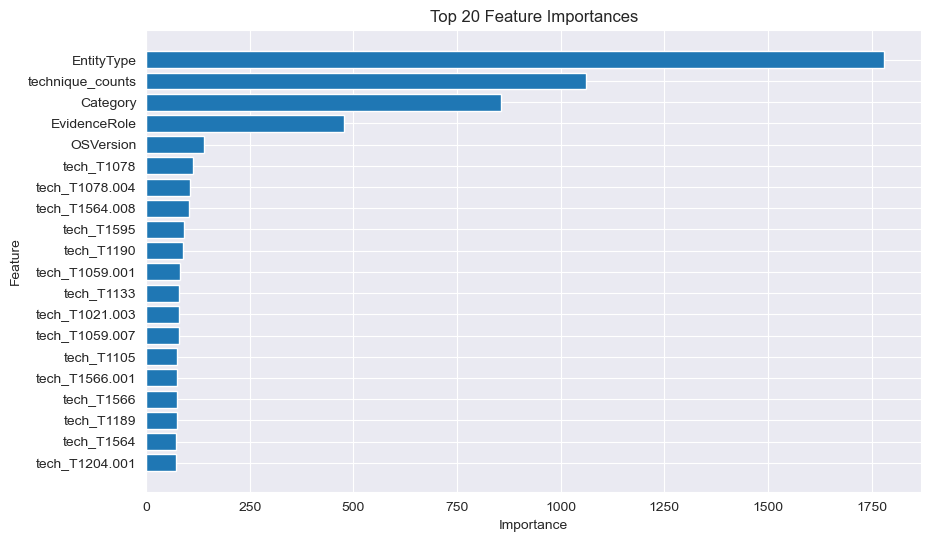

In [21]:
# Feature Importance Analysis


# Plot the top 20 important features
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'][:20], feature_importances['importance'][:20])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [22]:

display(y_test.head())
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")
logger.info("Model accuracy on test set: %.2f", accuracy)

0    0
1    1
2    0
3    1
4    0
Name: Outcome, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82    217534
           1       0.76      0.68      0.72    150902

    accuracy                           0.78    368436
   macro avg       0.78      0.77      0.77    368436
weighted avg       0.78      0.78      0.78    368436

Confusion Matrix:
[[185252  32282]
 [ 48248 102654]]
Accuracy Score: 0.78


In [23]:

def plot_lgbm_feature_importances(lgb_model, feature_columns, top_n=20):
    """
    Plot the top-N feature importances from a trained LightGBM model.
    """
    try:
        importances = lgb_model.booster_.feature_importance(importance_type='gain')
        sorted_indices = np.argsort(importances)[::-1][:top_n]

        # Align features and importances
        top_features = [feature_columns[i] for i in sorted_indices]
        top_importances = np.array(importances)[sorted_indices]

        # Plot
        plt.figure(figsize=(12, 6))
        plt.title(f"Top {top_n} Feature Importances (LightGBM)")
        plt.barh(range(len(top_features)), top_importances, color="blue", align="center")
        plt.yticks(range(len(top_features)), top_features)
        plt.gca().invert_yaxis()  # Flip Y-axis for visual clarity
        plt.xlabel("Importance Score (Gain)")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred while plotting feature importances: {str(e)}")


In [24]:



def plot_roc_auc(y_test, y_pred_proba):
    """
    Plot the ROC curve and display the AUC score.
    """
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="green")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [25]:



def plot_confusion_matrix_normalized(y_test, y_pred_proba, threshold=0.5):
    """
    Plot a normalized confusion matrix for predictions based on a specified threshold.
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=1, keepdims=True), display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.show()


In [26]:
def plot_precision_recall_thresholds(y_test, y_pred_proba, thresholds=np.arange(0.1, 1.0, 0.1)):
    """
    Plot precision, recall, and F1 scores for multiple classification thresholds.
    """
    precision_scores = []
    recall_scores = []

    for t in thresholds:
        preds = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    # Calculate F1 scores
    f1_scores = [
        2 * (p * r) / (p + r) if (p + r) > 0 else 0
        for p, r in zip(precision_scores, recall_scores)
    ]

    # Plot
    x = np.arange(len(thresholds))
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.15, precision_scores, width=0.3, label="Precision", color="orange")
    plt.bar(x + 0.15, recall_scores, width=0.3, label="Recall", color="blue")
    plt.bar(x + 0.30, f1_scores, width=0.3, label="F1 Score", color="green")
    plt.xticks(x, [f"{t:.1f}" for t in thresholds])
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision and Recall at Different Thresholds")
    plt.legend()
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


## Interactive Decision Support Query

The interactive widget below allows a security analyst to input values for a subset of features
(for example, `DetectorId` and `MitreTechniques_count`) and receive an immediate prediction from
the trained Random Forest model. (In practice, you might expand this to include more features.)


In [27]:
def plot_histogram(data, column, bins=20, title="Histogram"):
    """
    Plot a histogram for a specific column in the given dataset.
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(data[column], bins=bins, kde=True, color='blue')
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [28]:


# Ensure `X_test` is loaded and non-empty
assert 'X_test' in locals() and not X_test.empty, "X_test is not defined or empty. Ensure it is loaded."

# Define the cardinality threshold for using dropdowns
CARDINALITY_THRESHOLD = 100

# Separate TTP features and other features
ttp_features = [feature for feature in X_test.columns if feature.startswith("tech_")]
other_features = [feature for feature in X_test.columns if feature not in ttp_features]

# Widgets for non-TTP features and additional technique count logic
feature_widgets = {}
for feature in other_features:
    unique_values = np.sort(X_test[feature].dropna().unique())  # Get unique values (drop NaNs if any)

    if len(unique_values) <= CARDINALITY_THRESHOLD:
        # For low-cardinality features, use a dropdown or select widget
        default_value = X_test[feature].iloc[0]
        if default_value not in unique_values:
            default_value = unique_values[0] if len(unique_values) > 0 else None

        feature_widgets[feature] = widgets.Dropdown(
            options=sorted(unique_values),
            value=default_value,  # Default to the first valid value
            description=feature,
            layout=widgets.Layout(width='80%'),
            style={'description_width': 'initial'}
        )
    else:
        # For high-cardinality features, use a regular slider
        min_value, max_value = int(X_test[feature].min()), int(X_test[feature].max())
        default_value = int(X_test[feature].mean())
        feature_widgets[feature] = widgets.IntSlider(
            value=default_value,  # Default to mean value rounded to integer
            min=min_value,
            max=max_value,
            step=1,  # Step is 1 for integers
            description=feature,
            layout=widgets.Layout(width='80%'),
            style={'description_width': 'initial'}
        )

# Multi-Select widget for TTPs
mitre_multiselect = widgets.SelectMultiple(
    options=sorted(ttp_features),
    description="Select TTPs:",
    layout={'width': '80%'},
    style={'description_width': 'initial'}
)

# Prediction output widget
prediction_output = widgets.Output()

# Prediction button
predict_button = widgets.Button(
    description="Get Prediction",
    button_style="primary",  # Styling: 'primary', 'success', 'info', 'warning', 'danger'
    icon="check",  # Button icon
)

# Set values and TTPs button
set_values_button = widgets.Button(
    description="Set Values & Select TTPs",
    button_style="success",  # Styling: 'primary', 'success', 'info', 'warning', 'danger'
    icon="magic",  # Button icon
)


# Prediction logic
def predict_outcome(selected_ttps, feature_values):
    try:
        # Validate TTP selection
        if len(selected_ttps) == 0:
            with prediction_output:
                prediction_output.clear_output()
                print("Error: No TTPs selected. Please select at least one TTP.")
            return

        # Copy the base input row for modifications
        base_input = X_test.iloc[0].copy()

        # Set TTP features
        selected_ttps_matched = [ttp for ttp in selected_ttps if ttp in base_input.index]
        unmatched_ttps = [ttp for ttp in selected_ttps if ttp not in base_input.index]

        # Set TTPs to 1 and others to 0
        base_input.update({ttp: 1 for ttp in selected_ttps_matched})
        base_input.update({ttp: 0 for ttp in ttp_features if ttp not in selected_ttps_matched})

        # Set values for non-TTP features from the widgets
        for feature, value in feature_values.items():
            base_input[feature] = value

        # Align input with the model's expected features
        base_input = base_input.reindex(lgb_model.feature_names_in_, fill_value=0)

        # Prepare input vector for prediction
        input_vector = base_input.values.reshape(1, -1)

        # Validate input dimensions match model requirements
        if input_vector.shape[1] != lgb_model.n_features_in_:
            raise ValueError(
                f"Feature mismatch: Input has {input_vector.shape[1]} features; model expects {lgb_model.n_features_in_}."
            )

        # Perform prediction
        prediction = lgb_model.predict(input_vector)
        probability = lgb_model.predict_proba(input_vector)[0, 1]

        # Output the results
        with prediction_output:
            prediction_output.clear_output()
            result = "TruePositive" if prediction[0] == 1 else "Negative"
            print(f"Prediction: {result}")
            print(f"Probability of Breach: {probability:.2f}")
            print("Selected TTPs:")
            for ttp in selected_ttps_matched:
                print(ttp[5:])
    except Exception as e:
        with prediction_output:
            prediction_output.clear_output()
            print(f"An error occurred: {str(e)}")


# Dropdown randomizer and TTP selector logic
def set_values_and_ttps(change):
    # Randomly select values for each dropdown
    for feature, widget in feature_widgets.items():
        if isinstance(widget, widgets.Dropdown):
            unique_values = [item for item in widget.options]
            if unique_values:
                widget.value = np.random.choice(unique_values)  # Randomly select one of the dropdown values

    # Use the updated technique_counts value from the corresponding widget
    num_ttps_to_select = feature_widgets["technique_counts"].value if "technique_counts" in feature_widgets else 1

    # Select the correct number of random TTPs
    randomly_selected_ttps = list(np.random.choice(
        ttp_features, min(num_ttps_to_select, len(ttp_features)), replace=False))
    mitre_multiselect.value = tuple(randomly_selected_ttps)


# Button click event handler for prediction
def on_predict_button_click(change):
    # Collect selected TTPs from the multi-select widget
    selected_ttps = list(mitre_multiselect.value)

    # Collect feature values from all feature widgets
    feature_values = {feature: widget.value for feature, widget in feature_widgets.items()}

    # Perform prediction
    predict_outcome(selected_ttps, feature_values)


# Bind the button click events
predict_button.on_click(on_predict_button_click)
set_values_button.on_click(set_values_and_ttps)

# Layout the interactive widgets
feature_widgets_layout = widgets.VBox([widget for widget in feature_widgets.values()])
ui = widgets.VBox([
    mitre_multiselect,
    feature_widgets_layout,
    widgets.HBox([predict_button, set_values_button]),  # Add buttons side by side
    prediction_output
])

display(ui)


## Dashboard for Data Exploration

The dashboard below is organized into three tabs with different visualization types:

1. **Histogram:** Distribution of DetectorId.
2. **Scatter Plot:** DetectorId vs. MitreTechniques_count with outcome coloring.
3. **Heatmap:** Correlation among selected features.

This dashboard provides a user-friendly interface for data exploration and inspection.


In [29]:
import ipywidgets as widgets

# Output areas for each visual
tabs = {
    "Correlation Heatmap": widgets.Output(),
    "Radar Chart": widgets.Output(),
    "UMAP Visualization": widgets.Output(),
    "Histogram": widgets.Output(),
    "Cluster Sizes": widgets.Output(),
    "PLSR Heatmap": widgets.Output(),
    "Feature Importances": widgets.Output(),
    "ROC Curve": widgets.Output(),
    "Confusion Matrix": widgets.Output(),
    "Precision and Recall": widgets.Output()
}

# Populate each tab by calling the visual functions
with tabs["Correlation Heatmap"]:
    plot_correlation_heatmap(correlation_matrix, target_column="Outcome")

# 'Radar Chart' Tab: Added interactivity for the user to select clusters
with tabs["Radar Chart"]:
    display(
        create_cluster_selector(cluster_normalized))  # Dynamically creates the dropdown and radar chart interactivity

with tabs["UMAP Visualization"]:
    plot_umap_visualization(correlation_data)

with tabs["Histogram"]:
    plot_histogram(correlation_data, column="technique_counts", title="Histogram of technique_counts")

with tabs["Cluster Sizes"]:
    plot_cluster_sizes(clusterer.labels_)

# PLSR Heatmap Tab
with tabs["PLSR Heatmap"]:
    compute_plsr_and_plot_corr_heatmap(X_train_df, y_train, feature_columns)

# LightGBM Feature Importances Tab
with tabs["Feature Importances"]:
    plot_lgbm_feature_importances(lgb_model, feature_columns)

# ROC Curve Tab
with tabs["ROC Curve"]:
    plot_roc_auc(y_test, y_pred_proba)

# Confusion Matrix Tab
with tabs["Confusion Matrix"]:
    plot_confusion_matrix_normalized(y_test, y_pred_proba)

# Precision and Recall at Thresholds Tab
with tabs["Precision and Recall"]:
    plot_precision_recall_thresholds(y_test, y_pred_proba)

# Create ipywidgets Tab
dashboard_tabs = widgets.Tab(
    children=[tabs[name] for name in tabs.keys()]
)
for i, name in enumerate(tabs.keys()):
    dashboard_tabs.set_title(i, name)

# Display the dashboard
display(dashboard_tabs)


## Placeholder for Industry-Appropriate Security Features

In an actual production environment, you would implement secure authentication,
encrypted communications, and rigorous logging. The following is a very basic placeholder
for a password check. **(Do not use in production!)**

In [30]:
def authenticate():
    """A simple (insecure) authentication function."""
    password = getpass.getpass("Enter password for dashboard access: ")
    if password == "securepassword":  # NEVER hard-code passwords in production!
        print("Authentication successful.")
        return True
    else:
        print("Authentication failed.")
        return False

# Uncomment the following lines to enable a simple authentication check before showing the dashboard.
# if authenticate():
#     display(dashboard_tabs)
# else:
#     print("Access Denied.")


## Summary

This notebook has:

- Loaded and cleaned the training and testing datasets from the `data/` folder.
- Discarded columns with excessive missing values and unnecessary identifiers.
- Derived a new feature (`MitreTechniques_count`) from `MitreTechniques`.
- Reduced the dependent variable (`IncidentGrade`) to a binary outcome.
- Selected and processed relevant features (with label encoding for categorical variables).
- Performed K-Means clustering and trained/evaluated a Random Forest classifier.
- Provided an interactive query widget for decision support.
- Built a simple dashboard with three visualization types.
- Included placeholder security and logging features.

You can now extend or deploy this tool as part of a larger decision-support system.


**End of Notebook**